In [38]:
import pymongo

print(pymongo.__version__)

4.7.2


In [39]:
conn = pymongo.MongoClient(host="localhost", port=27017)

client = conn['cycle']

client.list_collection_names()

['rental_info_aggregated',
 'cycle_usage_monthly',
 'rental_info',
 'cycle_breakdown_rental_correlation',
 'station_master',
 'cycle_aggregated',
 'cycle_part_breakdown_correlation',
 'rental_hour_summary',
 'rental_shop_info',
 'rental_place_monthly',
 'broken_history',
 'cycle_count_rental_place_monthly']

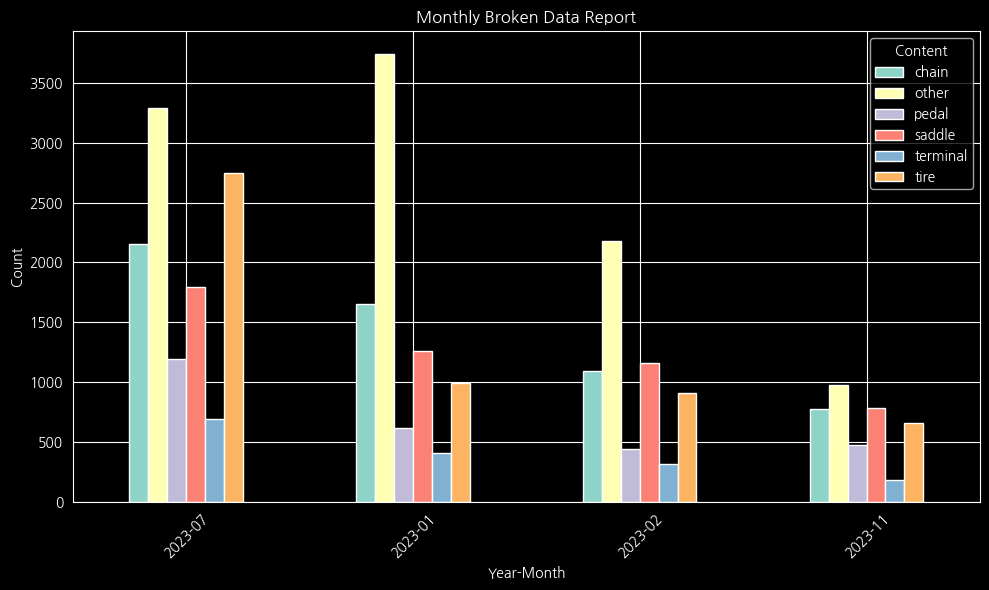

In [40]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = '/Users/jiny/Library/Fonts/NanumGothic-Regular.ttf'  # 사용하려는 폰트 경로로 설정
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


# MongoDB 연결 설정
client = MongoClient('mongodb://localhost:27017/')
results = client['cycle']['broken_history'].aggregate([
    {
        '$project': {
            'year': { '$year': '$created_at' },
            'month': { '$month': '$created_at' },
            'content': { '$trim': { 'input': '$content' } }  # content 필드의 좌우 공백 제거
        }
    }, {
        '$group': {
            '_id': { 'year': '$year', 'month': '$month' },
            'total_count': { '$sum': 1 },
            'details': { '$push': { 'content': '$content' } }
        }
    }, {
        '$unwind': '$details'
    }, {
        '$group': {
            '_id': {
                'year': '$_id.year',
                'month': '$_id.month',
                'content': '$details.content'
            },
            'count': { '$sum': 1 }
        }
    }, {
        '$group': {
            '_id': {
                'year': '$_id.year',
                'month': '$_id.month'
            },
            'total_count': { '$first': '$count' },
            'details': {
                '$push': {
                    'content': '$_id.content',
                    'count': '$count'
                }
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'year': '$_id.year',
            'month': '$_id.month',
            'count': '$total_count',
            'detail': '$details'
        }
    }, {
        '$sort': { 'year': 1, 'month': 1 }
    }
])

# content 값을 변환하기 위한 매핑
content_mapping = {
    "기타": "other",
    "단말기": "terminal",
    "안장": "saddle",
    "체인": "chain",
    "타이어": "tire",
    "페달": "pedal"
}

# 데이터를 다중 막대 그래프 형식으로 변환
data = []
for result in results:
    year_month = f"{result['year']}-{result['month']:02d}"
    for detail in result['detail']:
        # content 값을 변환
        content_english = content_mapping.get(detail['content'], detail['content'])
        data.append([year_month, content_english, detail['count']])

df = pd.DataFrame(data, columns=['Year-Month', 'Content', 'Count'])

# 월별 총 카운트를 계산하여 정렬
total_counts = df.groupby('Year-Month')['Count'].sum().sort_values(ascending=False)
df['Year-Month'] = pd.Categorical(df['Year-Month'], categories=total_counts.index, ordered=True)

# 다중 막대 그래프를 위한 데이터 피벗
pivot_df = df.pivot(index='Year-Month', columns='Content', values='Count').fillna(0)

# 다중 막대 그래프 그리기
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Monthly Broken Data Report')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Content')
plt.tight_layout()
plt.show()

In [41]:
import plotly.graph_objs as go

# 월별 자전거 사용량
coll = client.cycle_usage_monthly.find().sort({'_id.month': 1})
x = []
trace = []
count = []
avg_minute = []
for document in coll:
    print(document)
    x.append(int(document['_id']['month']))
    count.append(int(document['count']))
    avg_minute.append(int(document['avg_minute']))

trace1 = go.Scatter(
    x = x,
    y = count,
    mode = 'lines+markers',
    name = 'count'
)

trace2 = go.Scatter(
    x = x,
    y = avg_minute,
    mode = 'lines',
    name = 'avg_minute'
)

data = [trace1]
fig = go.Figure(data=data)
fig.show()

data = [trace2]
fig = go.Figure(data=data)
fig.show()

# 가격 책정 전략: 월간 사용량에 따른 평균 사용 시간 변화에 대한 통찰력을 통해 가격 책정 전략을 알릴 수 있습니다.
# 예를 들어, 사용량이 적은 달에 장기 임대에 대해 할인을 제공하면 수요 균형을 맞추고 수익을 높이는 데 도움이 될 수 있습니다.

# 여름에는 사용 횟수와 함께 사용 시간도 줄어든다. 이 때 필요에 따른 가격 정책을 펼칠 수 있다.

TypeError: 'Collection' object is not callable. If you meant to call the 'find' method on a 'Database' object it is failing because no such method exists.

In [ ]:
# 자전거 사용 history

import plotly.express as px

# 월별 자전거 사용량
month = 7
coll = client.rental_place_monthly.find({'_id.month': month}).sort({'rentalCount': -1}).limit(20)
x = []
trace = []
rental_place = []
rental_count = []
for document in coll:
    # print(document)
    x.append(int(document['_id']['month']))
    rental_place.append(document['_id']['rental_place'])
    rental_count.append(int(document['rentalCount']))

fig = px.pie(
    names=rental_place,
    values=rental_count,
    title='month: {}'.format(month),
)

fig.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregation pipeline to find the least rented bikes at "CBS방송국 앞"
pipeline = [
    {
        '$match': {
            'rental_place': 'CBS방송국 앞'
        }
    },
    {
        '$sort': {'month': 1, 'rental_count': 1}  # Sort by month and rental_count in ascending order
    },
    {
        '$group': {
            '_id': '$month',
            'least_rented_bikes': {
                '$push': {
                    'cycle_num': '$cycle_num',
                    'rental_count': '$rental_count'
                }
            }
        }
    },
    {
        '$project': {
            'month': '$_id',
            'least_rented_bikes': {'$slice': ['$least_rented_bikes', 5]},  # Select the top 5 least rented bikes
            '_id': 0
        }
    },
    {
        '$unwind': '$least_rented_bikes'
    },
    {
        '$project': {
            'month': 1,
            'cycle_num': '$least_rented_bikes.cycle_num',
            'rental_count': '$least_rented_bikes.rental_count'
        }
    },
    {
        '$sort': {'month': 1, 'rental_count': 1}
    }
]

# Execute the aggregation pipeline
result = client.cycle_count_rental_place_monthly.aggregate(pipeline)

# Process the results
data = []
for doc in result:
    data.append(doc)

# Convert the results to a DataFrame
df = pd.DataFrame(data)

# Ensure cycle_num is string and month is integer
df['cycle_num'] = df['cycle_num'].astype(str)
df['month'] = df['month'].astype(int)

# Plotting
plt.figure(figsize=(12, 8))
months = df['month'].unique()

for i, month in enumerate(months):
    subset = df[df['month'] == month]
    plt.scatter([i] * len(subset), subset['cycle_num'], s=1000, label=f'Month {month}')
    for j, cycle_num in enumerate(subset['cycle_num']):
        plt.text(i, cycle_num, cycle_num, color='black', ha='center', va='center')

# Customize plot
plt.xlabel('Month')
plt.ylabel('Cycle Number')
plt.title('Top 5 Least Rented Bicycles per Month at CBS방송국 앞')
plt.xticks(range(len(months)), [f'Month {month}' for month in months])
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # To have cycle numbers top to bottom
plt.tight_layout()
plt.show()

In [ ]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

# MongoDB 연결 설정
client = MongoClient('mongodb://localhost:27017/')
db = client['cycle']

# 저장된 결과 불러오기
result = db.cycle_aggregated.find_one()

# rental_hours와 return_hours 추출
rental_hours = result['rental_hours']
return_hours = result['return_hours']

# Extracting data for visualization
rental_hours_data = {doc['_id']: doc['count'] for doc in rental_hours}
return_hours_data = {doc['_id']: doc['count'] for doc in return_hours}

# Creating lists of hours and counts for plotting
hours = range(24)
rental_counts = [rental_hours_data.get(hour, 0) for hour in hours]
return_counts = [return_hours_data.get(hour, 0) for hour in hours]

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(hours, rental_counts, label='Rentals', marker='o', color='#1f77b4')
plt.plot(hours, return_counts, label='Returns', marker='o', color='#ff7f0e')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rentals/Returns')
plt.title('Bike Rentals and Returns by Hour of the Day')
plt.xticks(hours)
plt.yticks(range(0, max(max(rental_counts), max(return_counts)) + 1, 1000000))  # Y축 레이블을 원하는 값으로 설정
plt.grid(True)
plt.legend()
plt.show()

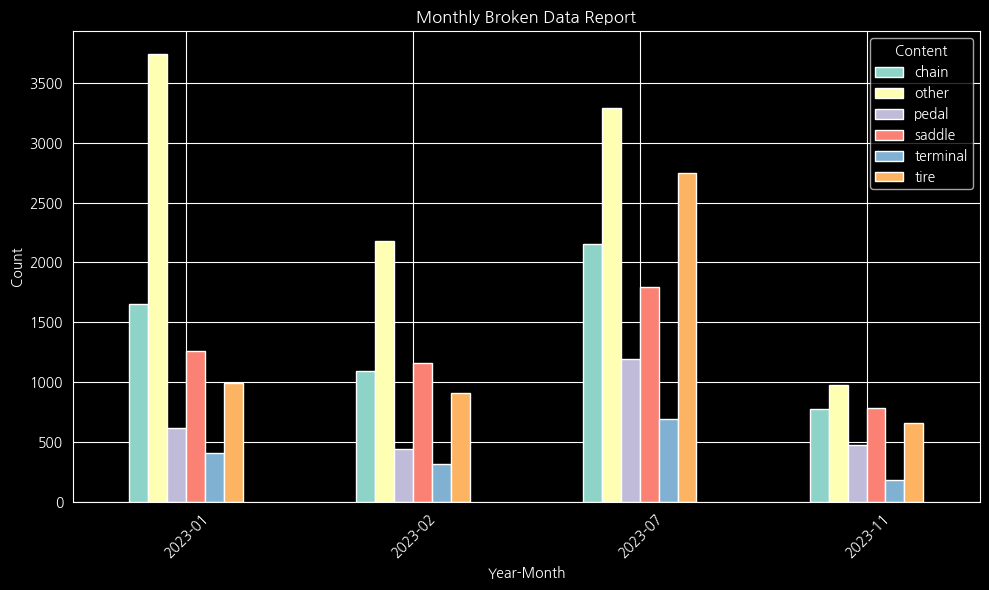

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

# MongoDB 연결 설정
client = MongoClient('mongodb://localhost:27017/')
results = list(client['cycle']['broken_history'].aggregate([
    {
        '$project': {
            'year': { '$year': '$created_at' },
            'month': { '$month': '$created_at' },
            'content': { '$trim': { 'input': '$content' } }  # content 필드의 좌우 공백 제거
        }
    }, {
        '$group': {
            '_id': { 'year': '$year', 'month': '$month' },
            'total_count': { '$sum': 1 },
            'details': { '$push': { 'content': '$content' } }
        }
    }, {
        '$unwind': '$details'
    }, {
        '$group': {
            '_id': {
                'year': '$_id.year',
                'month': '$_id.month',
                'content': '$details.content'
            },
            'count': { '$sum': 1 }
        }
    }, {
        '$group': {
            '_id': {
                'year': '$_id.year',
                'month': '$_id.month'
            },
            'total_count': { '$first': '$count' },
            'details': {
                '$push': {
                    'content': '$_id.content',
                    'count': '$count'
                }
            }
        }
    }, {
        '$project': {
            '_id': 0,
            'year': '$_id.year',
            'month': '$_id.month',
            'count': '$total_count',
            'detail': {
                '$sortArray': {
                    'input': '$details',
                    'sortBy': { 'count': -1 }
                }
            }
        }
    }, {
        '$sort': { 'year': 1, 'month': 1 }
    }
]))

# 결과가 비어 있는지 확인
if not results:
    print("No data found from MongoDB query.")
else:
    # content 값을 변환하기 위한 매핑
    content_mapping = {
        "기타": "other",
        "단말기": "terminal",
        "안장": "saddle",
        "체인": "chain",
        "타이어": "tire",
        "페달": "pedal"
    }

    # 데이터를 다중 막대 그래프 형식으로 변환
    data = []
    for result in results:
        year_month = f"{result['year']}-{result['month']:02d}"
        for detail in result['detail']:
            # content 값을 변환
            content_english = content_mapping.get(detail['content'], detail['content'])
            data.append([year_month, content_english, detail['count']])

    # 데이터프레임 생성
    df = pd.DataFrame(data, columns=['Year-Month', 'Content', 'Count'])

    # 데이터 타입 변환
    df['Count'] = df['Count'].astype(int)

    # Year-Month를 문자열로 유지하고 오름차순으로 정렬
    df = df.sort_values(['Year-Month', 'Count'], ascending=[True, False])

    # 다중 막대 그래프를 위한 데이터 피벗
    pivot_df = df.pivot(index='Year-Month', columns='Content', values='Count').fillna(0)

    # 다중 막대 그래프 그리기
    pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))

    plt.title('Monthly Broken Data Report')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Content')
    plt.tight_layout()
    plt.show()

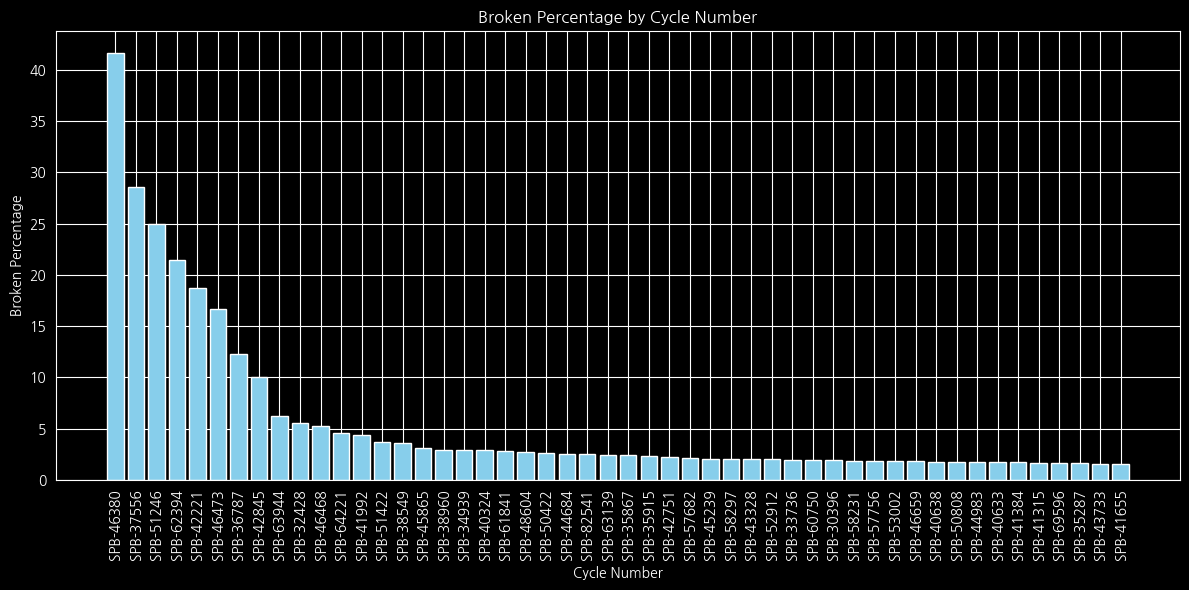

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

# Requires the PyMongo package.
# https://api.mongodb.com/python/current
client = MongoClient('mongodb://localhost:27017/')
result = client['cycle']['rental_info'].aggregate(
[
    {
        '$group': {
            '_id': '$cycle_num',
            'rental_count': {
                '$sum': 1
            }
        }
    }, {
        '$lookup': {
            'from': 'broken_history',
            'localField': '_id',
            'foreignField': 'cycle_num',
            'as': 'broken_info'
        }
    }, {
        '$addFields': {
            'broken_count': {
                '$size': '$broken_info'
            }
        }
    }, {
        '$match': {
            'rental_count': {
                '$ne': 0
            }
        }
    }, {
        '$addFields': {
            'broken_percentage': {
                '$multiply': [
                    {
                        '$divide': [
                            '$broken_count', '$rental_count'
                        ]
                    }, 100
                ]
            }
        }
    }, {
        '$project': {
            'cycle_num': '$_id',
            'rental_count': 1,
            'broken_count': 1,
            'broken_percentage': {
                '$round': [
                    '$broken_percentage', 2
                ]
            }
        }
    }, {
        '$sort': {
            'broken_percentage': -1,
            'rental_count': -1
        }
    }, {
        '$limit': 50
    }
]
)

# 결과를 DataFrame으로 변환
data = list(result)
df = pd.DataFrame(data)

# 막대차트 시각화
plt.figure(figsize=(12, 6))
plt.bar(df['cycle_num'], df['broken_percentage'], color='skyblue')
plt.xlabel('Cycle Number')
plt.ylabel('Broken Percentage')
plt.title('Broken Percentage by Cycle Number')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

client.close()

Indexes for 'rental_info': {'_id_': {'v': 2, 'key': [('_id', 1)]}, 'user.usr_cls_cd_1_rental_place_1': {'v': 2, 'key': [('user.usr_cls_cd', 1), ('rental_place', 1)]}, 'rental_station_id_1': {'v': 2, 'key': [('rental_station_id', 1)]}, 'cycle_num_1_rental_station_id_1': {'v': 2, 'key': [('cycle_num', 1), ('rental_station_id', 1)]}}
Indexes for 'broken_history': {'_id_': {'v': 2, 'key': [('_id', 1)]}, 'cycle_num_1_content_1': {'v': 2, 'key': [('cycle_num', 1), ('content', 1)]}, 'cycle_num_1_created_at_1': {'v': 2, 'key': [('cycle_num', 1), ('created_at', 1)]}}
Query execution time before indexing: 52.52 seconds
Query execution time after indexing: 48.07 seconds


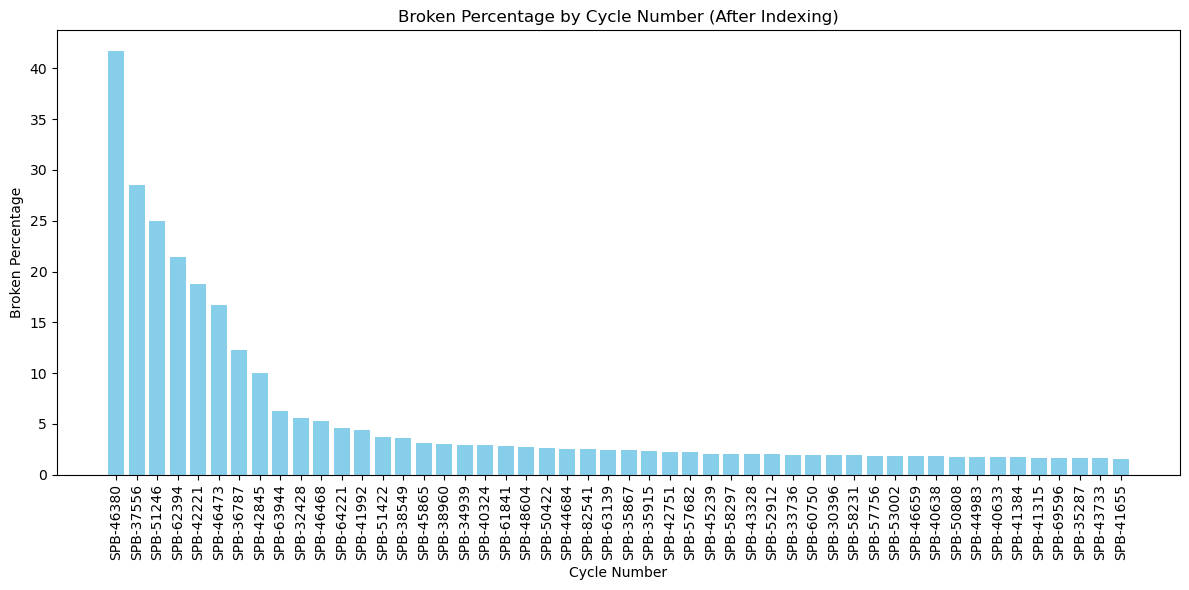

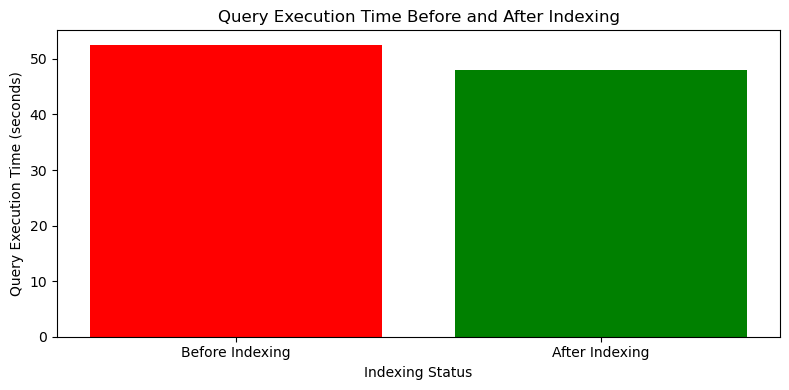

In [6]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

# MongoDB 연결 설정
client = MongoClient('mongodb://localhost:27017/')
db = client['cycle']

# 기존 인덱스 삭제 (필요시)
db['rental_info'].drop_index('cycle_num_1')
db['broken_history'].drop_index('cycle_num_1')

# cycle_num 및 관련 필드에 대한 복합 인덱스 추가
db['rental_info'].create_index([('cycle_num', 1), ('rental_station_id', 1)])
db['broken_history'].create_index([('cycle_num', 1), ('created_at', 1)])

# 인덱스가 잘 추가되었는지 확인
indexes_rental_info = db['rental_info'].index_information()
indexes_broken_history = db['broken_history'].index_information()

print("Indexes for 'rental_info':", indexes_rental_info)
print("Indexes for 'broken_history':", indexes_broken_history)

# 쿼리 실행 및 시간 측정 함수
def measure_query_time():
    start_time = time.time()
    result = db['rental_info'].aggregate([
        {
            '$group': {
                '_id': '$cycle_num',
                'rental_count': {
                    '$sum': 1
                }
            }
        }, {
            '$lookup': {
                'from': 'broken_history',
                'localField': '_id',
                'foreignField': 'cycle_num',
                'as': 'broken_info'
            }
        }, {
            '$addFields': {
                'broken_count': {
                    '$size': '$broken_info'
                }
            }
        }, {
            '$match': {
                'rental_count': {
                    '$ne': 0
                }
            }
        }, {
            '$addFields': {
                'broken_percentage': {
                    '$multiply': [
                        {
                            '$divide': [
                                '$broken_count', '$rental_count'
                            ]
                        }, 100
                    ]
                }
            }
        }, {
            '$project': {
                'cycle_num': '$_id',
                'rental_count': 1,
                'broken_count': 1,
                'broken_percentage': {
                    '$round': [
                        '$broken_percentage', 2
                    ]
                }
            }
        }, {
            '$sort': {
                'broken_percentage': -1,
                'rental_count': -1
            }
        }, {
            '$limit': 50
        }
    ])
    end_time = time.time()
    return list(result), end_time - start_time

# 인덱스 추가 전 쿼리 실행 및 시간 측정
data_before_indexing, time_before_indexing = measure_query_time()
print(f"Query execution time before indexing: {time_before_indexing:.2f} seconds")

# 인덱스 추가 후 쿼리 실행 및 시간 측정
data_after_indexing, time_after_indexing = measure_query_time()
print(f"Query execution time after indexing: {time_after_indexing:.2f} seconds")

# 결과를 DataFrame으로 변환
df_before = pd.DataFrame(data_before_indexing)
df_after = pd.DataFrame(data_after_indexing)

# 막대차트 시각화 (인덱싱 후 결과)
plt.figure(figsize=(12, 6))
plt.bar(df_after['cycle_num'], df_after['broken_percentage'], color='skyblue')
plt.xlabel('Cycle Number')
plt.ylabel('Broken Percentage')
plt.title('Broken Percentage by Cycle Number (After Indexing)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 시간 비교 시각화
plt.figure(figsize=(8, 4))
plt.bar(['Before Indexing', 'After Indexing'], [time_before_indexing, time_after_indexing], color=['red', 'green'])
plt.xlabel('Indexing Status')
plt.ylabel('Query Execution Time (seconds)')
plt.title('Query Execution Time Before and After Indexing')
plt.tight_layout()
plt.show()

client.close()